# 02 Train and test a random forest model
## load and process data, split to train/valid/test sets and train a two stage random-forest model

In [1]:
import pickle
from pathlib import Path

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
from matplotlib.colors import LogNorm
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

In /home/labs/fleishman/jonathaw/Code/anaconda3/envs/dees-seq-analysis/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/labs/fleishman/jonathaw/Code/anaconda3/envs/dees-seq-analysis/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/labs/fleishman/jonathaw/Code/anaconda3/envs/dees-seq-analysis/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/labs/fleishman/jonathaw/Code/anaconda3/envs/dees-seq-analysis/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle

In [2]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000):
        display(df)

## load experimental data
the data includes multiple columns that are unecessary for training such as previous predictions, NGS count/frequency/enrichment.
#### trainable columns consist of:
- the amino acid at each variable position
- total number of mutations (num_muts)
- the difference in PSSM score between the WT and the mutation (_dPSSM)
- the biochemical category of the mutation in each position (_cat)
- the difference in SASA between the WT and the mutation (_dSASA)
- has the biochemical category changed for each position (cat_change)
- number of mutations in each neigborhood (bubble, bub)
- number of mutations at specific regions (changes_on_)

In [3]:
all_data_df = pd.read_csv("./ngs_df.csv")
display_all(all_data_df)
print(all_data_df.shape)

,pseudo_prot,sample_name,num_muts,count,assign,predicted,L42,L44,V61,T65,V68,Q69,S72,Q94,T108,V112,N121,Y145,H148,V150,T167,H181,N185,T203,S205,L220,E222,V224,L42_dSASA,L44_dSASA,V61_dSASA,T65_dSASA,V68_dSASA,Q69_cat_change,Q69_dSASA,S72_cat_change,S72_dSASA,Q94_cat_change,Q94_dSASA,T108_cat_change,T108_dSASA,V112_dSASA,N121_cat_change,N121_dSASA,Y145_cat_change,Y145_dSASA,H148_cat_change,H148_dSASA,V150_dSASA,T167_cat_change,T167_dSASA,H181_cat_change,H181_dSASA,N185_cat_change,N185_dSASA,T203_cat_change,T203_dSASA,S205_cat_change,S205_dSASA,L220_dSASA,E222_cat_change,E222_dSASA,V224_dSASA,changes_on_helix,changes_on_back,changes_on_front,changes_on_hbonds,L42_dPSSM,L44_dPSSM,V61_dPSSM,V68_dPSSM,Q69_dPSSM,S72_dPSSM,Q94_dPSSM,T108_dPSSM,V112_dPSSM,N121_dPSSM,Y145_dPSSM,H148_dPSSM,V150_dPSSM,T167_dPSSM,H181_dPSSM,N185_dPSSM,T203_dPSSM,S205_dPSSM,L220_dPSSM,E222_dPSSM,V224_dPSSM,mean_dSASA,mean_dPSSM,bub_L42,bub_L44,bub_V61,bub_V68,bub_Q69,bub_V112,bub_Y145,bub_V150,bub_T167,bub_H181,bub_L220,bub_V224,bub_S72,bub_T108,bub_N185,bub_max,bub_mean,Q69_cat,S72_cat,Q94_cat,T108_cat,N121_cat,Y145_cat,H148_cat,T167_cat,H181_cat,N185_cat,T203_cat,S205_cat,E222_cat
0,LLVTVQSQVVNMHVVVNTSLEI,nohbonds H AmCyan 1,5,3.0,C,G/C,L,L,V,T,V,Q,S,Q,V,V,N,M,H,V,V,V,N,T,S,L,E,I,0.0,0.0,0.00,0.00,0.00,False,0.00,False,0.00,False,0.0,True,-14.50,0.00,False,0.0,True,29.64,False,0.0,0.00,True,-14.5,True,38.15,False,0.0,False,0.0,False,0.0,0.0,False,0.0,-27.59,0,0,1,0,0,0,0,0,0,0,0,4,0,0,4,0,0,1,10,0,0,0,0,0,2,0.509091,1.000000,1,0,1,1,0,0,3,2,3,3,1,1,1,1,0,3.0,1.3125,polar,polar,polar,h_phobic,polar,h_phobic,aromatic,h_phobic,h_phobic,polar,polar,polar,negative
1,LLVTVQSQVVNMHVVYNTSVEI,nohbonds H AmCyan 1,6,1.0,G/C,U,L,L,V,T,V,Q,S,Q,V,V,N,M,H,V,V,Y,N,T,S,V,E,I,0.0,0.0,0.00,0.00,0.00,False,0.00,False,0.00,False,0.0,True,-14.50,0.00,False,0.0,True,29.64,False,0.0,0.00,True,-14.5,False,-38.76,False,0.0,False,0.0,False,0.0,38.4,False,0.0,-27.59,0,0,1,0,0,0,0,0,0,0,0,4,0,0,4,0,0,1,7,0,0,0,3,0,2,-1.241364,1.000000,2,1,2,1,0,0,4,2,3,3,2,1,1,1,0,4.0,1.6875,polar,polar,polar,h_phobic,polar,h_phobic,aromatic,h_phobic,aromatic,polar,polar,polar,negative
2,LLVTVQSQVVNVHVTHNTSVEI,nohbonds H AmCyan 1,4,2.0,G/C,G/C,L,L,V,T,V,Q,S,Q,V,V,N,V,H,V,T,H,N,T,S,V,E,I,0.0,0.0,0.00,0.00,0.00,False,0.00,False,0.00,False,0.0,True,-14.50,0.00,False,0.0,True,76.91,False,0.0,0.00,False,0.0,False,0.00,False,0.0,False,0.0,False,0.0,38.4,False,0.0,-27.59,0,0,1,0,0,0,0,0,0,0,0,4,0,0,5,0,0,0,0,0,0,0,3,0,2,3.328182,0.666667,2,1,2,1,0,0,2,1,1,1,2,1,1,1,0,2.0,1.1250,polar,polar,polar,h_phobic,polar,h_phobic,aromatic,polar,aromatic,polar,polar,polar,negative
3,LLVTVQSQVVNVHVTHNTSVEV,nohbonds H AmCyan 1,3,1.0,G/C,G,L,L,V,T,V,Q,S,Q,V,V,N,V,H,V,T,H,N,T,S,V,E,V,0.0,0.0,0.00,0.00,0.00,False,0.00,False,0.00,False,0.0,True,-14.50,0.00,False,0.0,True,76.91,False,0.0,0.00,False,0.0,False,0.00,False,0.0,False,0.0,False,0.0,38.4,False,0.0,0.00,0,0,1,0,0,0,0,0,0,0,0,4,0,0,5,0,0,0,0,0,0,0,3,0,0,4.582273,0.571429,1,1,2,0,0,0,2,0,1,1,2,0,0,1,0,2.0,0.8125,polar,polar,polar,h_phobic,polar,h_phobic,aromatic,polar,aromatic,polar,polar,polar,negative
4,LLASVQSQTVNYHVVHNTSLEI,nohbonds H AmCyan 1,4,1.0,G/C,G/C,L,L,A,S,V,Q,S,Q,T,V,N,Y,H,V,V,H,N,T,S,L,E,I,0.0,0.0,47.72,19.54,0.00,False,0.00,False,0.00,False,0.0,False,0.00,0.00,False,0.0,False,0.00,False,0.0,0.00,True,-14.5,False,0.00,False,0.0,False,0.0,False,0.0,0.0,False,0.0,-27.59,1,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,1.144091,0.333333,1,0,1,1,0,0,2,2,1,1,1,1,1,0,0,2.0,0.8750,polar,polar,polar,polar,polar,aromatic,aromatic,h_phobic,aromatic,polar,polar,polar,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

(181433, 120)


#### drop unecessary columns

In [4]:
all_data_df = all_data_df[
    [
        "num_muts",
        "assign",
        "changes_on_helix",
        "changes_on_back",
        "changes_on_front",
        "L42",
        "V61",
        "T65",
        "V68",
        "Q69",
        "S72",
        "T108",
        "V112",
        "Y145",
        "V150",
        "T167",
        "H181",
        "L220",
        "V224",
        "H181_cat",
        "H181_cat_change",
        "H181_dPSSM",
        "H181_dSASA",
        "L220_dPSSM",
        "L220_dSASA",
        "L42_dPSSM",
        "L42_dSASA",
        "Q69_cat",
        "Q69_cat_change",
        "Q69_dPSSM",
        "Q69_dSASA",
        "S72_cat",
        "S72_cat_change",
        "S72_dPSSM",
        "S72_dSASA",
        "T108_cat",
        "T108_cat_change",
        "T108_dPSSM",
        "T108_dSASA",
        "T167_cat",
        "T167_cat_change",
        "T167_dPSSM",
        "T167_dSASA",
        "T65_dSASA",
        "V112_dPSSM",
        "V112_dSASA",
        "V150_dPSSM",
        "V150_dSASA",
        "V224_dPSSM",
        "V224_dSASA",
        "V61_dPSSM",
        "V61_dSASA",
        "V68_dPSSM",
        "V68_dSASA",
        "Y145_cat",
        "Y145_cat_change",
        "Y145_dPSSM",
        "Y145_dSASA",
        "bub_H181",
        "bub_L220",
        "bub_L42",
        "bub_Q69",
        "bub_S72",
        "bub_T108",
        "bub_T167",
        "bub_V112",
        "bub_V150",
        "bub_V224",
        "bub_V61",
        "bub_V68",
        "bub_Y145",
        "bub_max",
        "bub_mean",
        "mean_dPSSM",
        "mean_dSASA",
    ]
]
all_poss = [
    "L42",
    "V61",
    "T65",
    "V68",
    "Q69",
    "S72",
    "T108",
    "V112",
    "Y145",
    "V150",
    "T167",
    "H181",
    "L220",
    "V224",
]

#### save the categorical codes for each position, and apply to the data frame

In [5]:
pos_to_mut_to_code = {}
for p in all_poss:
    mut_to_code = {aa: i for i, aa in enumerate(sorted(all_data_df[p].unique()))}
    all_data_df[p] = all_data_df[p].map(mut_to_code)
    pos_to_mut_to_code[p] = mut_to_code
pos_to_mut_to_code

{'L42': {'L': 0, 'V': 1},
 'V61': {'A': 0, 'L': 1, 'V': 2},
 'T65': {'S': 0, 'T': 1},
 'V68': {'A': 0, 'M': 1, 'V': 2},
 'Q69': {'A': 0, 'L': 1, 'P': 2, 'Q': 3},
 'S72': {'A': 0, 'C': 1, 'S': 2, 'T': 3, 'V': 4},
 'T108': {'E': 0, 'I': 1, 'L': 2, 'T': 3, 'V': 4},
 'V112': {'I': 0, 'V': 1},
 'Y145': {'A': 0, 'F': 1, 'I': 2, 'M': 3, 'S': 4, 'T': 5, 'V': 6, 'Y': 7},
 'V150': {'I': 0, 'V': 1},
 'T167': {'T': 0, 'V': 1},
 'H181': {'F': 0, 'H': 1, 'I': 2, 'L': 3, 'V': 4, 'Y': 5},
 'L220': {'L': 0, 'V': 1},
 'V224': {'I': 0, 'V': 1}}

#### change all biochemical categroy columns to codes

In [6]:
cat_to_code = {
    c: i
    for i, c in enumerate(
        sorted(
            np.unique(
                all_data_df[
                    [c for c in all_data_df.columns if c.endswith("_cat")]
                ].values
            )
        )
    )
}
for col in [c for c in all_data_df.columns if c.endswith("_cat")]:
    all_data_df[col] = all_data_df[col].map(cat_to_code)
cat_to_code

{'aromatic': 0, 'h_phobic': 1, 'negative': 2, 'polar': 3}

In [7]:
display_all(all_data_df)

,num_muts,assign,changes_on_helix,changes_on_back,changes_on_front,L42,V61,T65,V68,Q69,S72,T108,V112,Y145,V150,T167,H181,L220,V224,H181_cat,H181_cat_change,H181_dPSSM,H181_dSASA,L220_dPSSM,L220_dSASA,L42_dPSSM,L42_dSASA,Q69_cat,Q69_cat_change,Q69_dPSSM,Q69_dSASA,S72_cat,S72_cat_change,S72_dPSSM,S72_dSASA,T108_cat,T108_cat_change,T108_dPSSM,T108_dSASA,T167_cat,T167_cat_change,T167_dPSSM,T167_dSASA,T65_dSASA,V112_dPSSM,V112_dSASA,V150_dPSSM,V150_dSASA,V224_dPSSM,V224_dSASA,V61_dPSSM,V61_dSASA,V68_dPSSM,V68_dSASA,Y145_cat,Y145_cat_change,Y145_dPSSM,Y145_dSASA,bub_H181,bub_L220,bub_L42,bub_Q69,bub_S72,bub_T108,bub_T167,bub_V112,bub_V150,bub_V224,bub_V61,bub_V68,bub_Y145,bub_max,bub_mean,mean_dPSSM,mean_dSASA
0,5,C,0,0,1,0,2,1,2,3,2,4,1,3,1,1,4,0,0,1,True,10,38.15,0,0.0,0,0.0,3,False,0,0.00,3,False,0,0.00,1,True,4,-14.50,1,True,1,-14.5,0.00,0,0.00,0,0.00,2,-27.59,0,0.00,0,0.00,1,True,4,29.64,3,1,1,0,1,1,3,0,2,1,1,1,3,3.0,1.3125,1.000000,0.509091
1,6,G/C,0,0,1,0,2,1,2,3,2,4,1,3,1,1,5,1,0,0,False,7,-38.76,3,38.4,0,0.0,3,False,0,0.00,3,False,0,0.00,1,True,4,-14.50,1,True,1,-14.5,0.00,0,0.00,0,0.00,2,-27.59,0,0.00,0,0.00,1,True,4,29.64,3,2,2,0,1,1,3,0,2,1,2,1,4,4.0,1.6875,1.000000,-1.241364
2,4,G/C,0,0,1,0,2,1,2,3,2,4,1,6,1,0,1,1,0,0,False,0,0.00,3,38.4,0,0.0,3,False,0,0.00,3,False,0,0.00,1,True,4,-14.50,3,False,0,0.0,0.00,0,0.00,0,0.00,2,-27.59,0,0.00,0,0.00,1,True,5,76.91,1,2,2,0,1,1,1,0,1,1,2,1,2,2.0,1.1250,0.666667,3.328182
3,3,G/C,0,0,1,0,2,1,2,3,2,4,1,6,1,0,1,1,1,0,False,0,0.00,3,38.4,0,0.0,3,False,0,0.00,3,False,0,0.00,1,True,4,-14.50,3,False,0,0.0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,1,True,5,76.91,1,2,1,0,0,1,1,0,0,0,2,0,2,2.0,0.8125,0.571429,4.582273
4,4,G/C,1,0,0,0,0,0,2,3,2,3,1,7,1,1,1,0,0,0,False,0,0.00,0,0.0,0,0.0,3,False,0,0.00,3,False,0,0.00,3,False,0,0.00,1,True,1,-14.5,19.54,0,0.00,0,0.00,2,-27.59,4,47.72,0,0.00,0,False,0,0.00,1,1,1,0,1,0,1,0,2,1,1,1,2,2.0,0.8750,0.333333,1.144091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181428,6,U,2,0,0,0,1,0,2,0,2,3,1,7,0,0,1,1,0,0,False,0,0.00,3,38.4,0,0.0,1,True,6,74.28,3,False,0,0.00,3,False,0,0.00,3,False,0,0.0,19.54,0,0.00,1,-27.59,2,-27.59,3,-38.40,0,0.00,0,False,0,0.00,1,2,2,2,1,0,0,0,3,2,2,1,2,3.0,1.4375,0.714286,1.756364
181429,7,U,4,0,1,0,0,0,1,0,0,3,1,1,1,0,1,1,1,0,False,0,0.00,3,38.4,0,0.0,1,True,6,74.28,1,True,0,13.68,3,False,0,0.00,3,False,0,0.0,19.54,0,0.00,0,0.00,0,0.00,4,47.72,2,-47.27,0,False,1,15.85,1,4,2,2,1,0,1,1,1,3,3,1,3,4.0,1.8750,0.761905,7.372727
181430,7,U,1,1,0,1,2,0,2,0,2,0,0,7,0,0,1,0,0,0,False,0,0.00,0,0.0,1,38.4,1,True,6,74.28,3,False,0,0.00,2,True,6,-43.91,3,False,0,0.0,19.54,1,-27.59,1,-27.59,2,-27.59,0,0.00,0,0.00,0,False,0,0.00,1,1,2,2,2,1,0,1,3,3,0,3,0,3.0,1.5625,0.809524,0.251818
181431,5,U,3,0,0,1,0,0,0,3,3,3,1,7,1,0,1,0,1,0,False,0,0.00,0,0.0,1,38.4,3,False,0,0.00,3,False,2,-19.54,3,False,0,0.00,3,False,0,0.0,19.54,0,0.00,0,0.00,0,0.00,4,47.72,5,47.72,0,False,0,0.00,0,3,2,1,2,0,0,1,0,3,1,2,1,3.0,1.3125,0.571429,6.083636


## split data to trainning/validation/testing data sets

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    all_data_df[[c for c in all_data_df.columns if c != "assign"]],
    all_data_df["assign"],
    test_size=0.2,
    random_state=42,
)
y_train_bw = y_train != "U"
y_test_bw = y_test != "U"

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)
y_train_bw = y_train != "U"
y_valid_bw = y_valid != "U"
print(f"Train {len(X_train)} {len(y_train)} {len(y_train_bw)}")
print(f"Valid  {len(X_valid)}  {len(y_valid)}  {len(y_valid_bw)}")
print(f"Test  {len(X_test)} {len(y_test)} {len(y_test_bw)}")

Train 116116 116116 116116
Valid  29030  29030  29030
Test  36287 36287 36287


## save/load data

In [9]:
X_train.to_csv("./X_train.csv", index=False)
X_valid.to_csv("./X_valid.csv", index=False)
X_test.to_csv("./X_test.csv", index=False)

y_train.to_csv("./y_train.csv", index=False)
y_valid.to_csv("./y_valid.csv", index=False)
y_test.to_csv("./y_test.csv", index=False)

y_train_bw = y_train != "U"
y_valid_bw = y_valid != "U"
y_test_bw = y_test != "U"

print(f"Train {len(X_train)} {len(y_train)} {len(y_train_bw)}")
print(f"Valid  {len(X_valid)}  {len(y_valid)}  {len(y_valid_bw)}")
print(f"Test  {len(X_test)} {len(y_test)} {len(y_test_bw)}")

Train 116116 116116 116116
Valid  29030  29030  29030
Test  36287 36287 36287


In [10]:
X_train = pd.read_csv("./X_train.csv")
X_valid = pd.read_csv("./X_valid.csv")
X_test = pd.read_csv("./X_test.csv")

y_train = pd.read_csv("./y_train.csv")
y_valid = pd.read_csv("./y_valid.csv")
y_test = pd.read_csv("./y_test.csv")

y_train_bw = y_train != "U"
y_valid_bw = y_valid != "U"
y_test_bw = y_test != "U"

print(f"Train {len(X_train)} {len(y_train)} {len(y_train_bw)}")
print(f"Valid  {len(X_valid)}  {len(y_valid)}  {len(y_valid_bw)}")
print(f"Test  {len(X_test)} {len(y_test)} {len(y_test_bw)}")

Train 116116 116116 116116
Valid  29030  29030  29030
Test  36287 36287 36287


## train the first random forest, which predicts whether a seqeunce is functional or not

In [11]:
lgbmc_fu = lgb.LGBMClassifier(
    #     class_weight="balanced",
    n_estimators=10000,
    random_state=42,
    num_leaves=5,
    bagging_freq=1,
    bagging_fraction=0.3,
    max_bin=50,
    feature_fraction=0.3,
    extra_trees=True,
    is_unbalance=True,
    max_depth=3,
    learning_rate=0.02,
    boosting="dart",
    path_smooth=5,
    #     device_type="gpu",  # 2
    objective="binary",
    #     tree_learner=
)
%timeit
lgbmc_fu.fit(
    X_train,
    y_train_bw,
    eval_set=[(X_train, y_train_bw), (X_valid, y_valid_bw)],
    verbose=500,
    #     categorical_feature=cat_feats,
)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	training's binary_logloss: 0.393828	valid_1's binary_logloss: 0.391085
[1000]	training's binary_logloss: 0.322877	valid_1's binary_logloss: 0.318649
[1500]	training's binary_logloss: 0.296815	valid_1's binary_logloss: 0.292175
[2000]	training's binary_logloss: 0.280839	valid_1's binary_logloss: 0.275892
[2500]	training's binary_logloss: 0.273612	valid_1's binary_logloss: 0.268612
[3000]	training's binary_logloss: 0.266209	valid_1's binary_logloss: 0.261228
[3500]	training's binary_logloss: 0.261274	valid_1's binary_logloss: 0.25635

LGBMClassifier(bagging_fraction=0.3, bagging_freq=1, boosting='dart',
               extra_trees=True, feature_fraction=0.3, is_unbalance=True,
               learning_rate=0.02, max_bin=50, max_depth=3, n_estimators=10000,
               num_leaves=5, objective='binary', path_smooth=5,
               random_state=42)

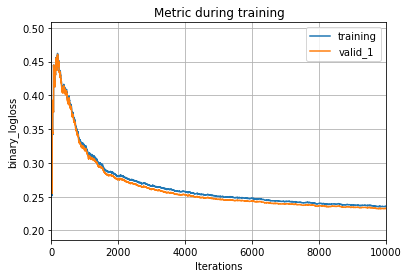

In [12]:
lgb.plot_metric(lgbmc_fu)
plt.show()

In [15]:
pickle.dump(lgbmc_fu, open("./estimators_first.pkl", "wb"))

In [16]:
y_valid_pred_bw = lgbmc_fu.predict(X_valid)
y_train_pred_bw = lgbmc_fu.predict(X_train)
y_test_pred_bw = lgbmc_fu.predict(X_test)

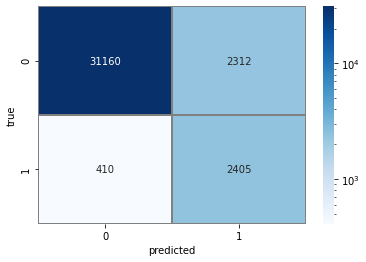

In [17]:
sns.heatmap(
    metrics.confusion_matrix(y_test_bw, y_test_pred_bw),
    annot=True,
    linewidths=0.01,
    cmap="Blues",
    linecolor="gray",
    fmt=".0f",
    norm=LogNorm(),
)
plt.ylabel("true")
plt.xlabel("predicted")

plt.show()

In [18]:
for name, y_, y_pred_ in zip(
    ["train", "valid", "test"],
    [y_train_bw, y_valid_bw, y_test_bw],
    [y_train_pred_bw, y_valid_pred_bw, y_test_pred_bw],
):
    print(name)
    print(metrics.classification_report(y_, y_pred_, target_names=["F", "U"]))

train
              precision    recall  f1-score   support

           F       0.99      0.93      0.96    107033
           U       0.51      0.86      0.64      9083

    accuracy                           0.92    116116
   macro avg       0.75      0.90      0.80    116116
weighted avg       0.95      0.92      0.93    116116

valid
              precision    recall  f1-score   support

           F       0.99      0.93      0.96     26699
           U       0.53      0.85      0.65      2331

    accuracy                           0.93     29030
   macro avg       0.76      0.89      0.81     29030
weighted avg       0.95      0.93      0.93     29030

test
              precision    recall  f1-score   support

           F       0.99      0.93      0.96     33472
           U       0.51      0.85      0.64      2815

    accuracy                           0.92     36287
   macro avg       0.75      0.89      0.80     36287
weighted avg       0.95      0.92      0.93     36287



In [19]:
metrics.balanced_accuracy_score(y_true=y_test_bw, y_pred=y_test_pred_bw)

0.8926395148226008

In [20]:
def get_predicted_as_functional(x: pd.DataFrame, y: np.array, y_pred: np.array):
    indices = np.where(y_pred == "U")[0]
    x["new_index"] = np.arange(len(x))
    return x.loc[~x["new_index"].isin(indices)].drop(columns="new_index"), np.delete(
        y, indices
    )


X_train_cl_pred, y_train_cl_pred = get_predicted_as_functional(
    X_train.copy(), y_train.copy(), y_train_pred_bw.copy()
)
X_valid_cl_pred, y_valid_cl_pred = get_predicted_as_functional(
    X_valid.copy(), y_valid.copy(), y_valid_pred_bw.copy()
)
X_test_cl_pred, y_test_cl_pred = get_predicted_as_functional(
    X_test.copy(), y_test.copy(), y_test_pred_bw.copy()
)

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [21]:
def remove_unsorted(x: pd.DataFrame, y: np.array):
    x["y"] = y
    x = x.loc[x["y"] != "U"]
    y = x["y"]
    x = x.drop(columns=["y"])
    return x, y


X_train_cl, y_train_cl = remove_unsorted(X_train.copy(), y_train.copy())
X_valid_cl, y_valid_cl = remove_unsorted(X_valid.copy(), y_valid.copy())
X_test_cl, y_test_cl = remove_unsorted(X_test.copy(), y_test.copy())

In [22]:
y_train_cl_pred.value_counts(), y_train_bw.value_counts()

(assign
 U         107033
 C           5032
 G           3153
 G/C          898
 dtype: int64,
 assign
 False     107033
 True        9083
 dtype: int64)

## train the second random forest, which predicts whether a sequence is GFP, AmCyan, both or non-functional

In [28]:
%%time
lgbmc = lgb.LGBMClassifier(  # CURRENTLY THE BEST CONFIG
    #     class_weight="balanced",
    n_estimators=10000,
    random_state=42,
    num_leaves=3,
    bagging_freq=1,
    bagging_fraction=0.1,
    max_bin=20,
    feature_fraction=0.1,
    extra_trees=True,
    is_unbalance=True,
    max_depth=2,
    learning_rate=0.1,  # 0.05
    boosting="dart",
    path_smooth=5,
    #     device_type="gpu",  # 2
)

lgbmc.fit(
    X_train_cl_pred,
    y_train_cl_pred,
    eval_set=[(X_train_cl_pred, y_train_cl_pred), (X_valid_cl_pred, y_valid_cl_pred)],
    verbose=500,
)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[500]	training's multi_logloss: 0.17594	valid_1's multi_logloss: 0.17986
[1000]	training's multi_logloss: 0.15937	valid_1's multi_logloss: 0.163557
[1500]	training's multi_logloss: 0.153419	valid_1's multi_logloss: 0.158076
[2000]	training's multi_logloss: 0.148927	valid_1's multi_logloss: 0.153781
[2500]	training's multi_logloss: 0.146425	valid_1's multi_logloss: 0.151697
[3000]	training's multi_logloss: 0.14402	valid_1's multi_logloss: 0.149342
[3500]	training's multi_logloss: 0.142152	valid_1's multi_logloss: 0.147952
[4000]	training's multi_logloss: 0.140933	valid_1's multi_logloss: 0.146873
[4500]	training's multi_logloss: 0.139625	valid_1's multi_logloss: 0.146329
[5000]	training's multi_logloss: 0.138317	valid_1's multi_logloss: 0.145073
[5500]	training's multi_logloss: 0.137438	valid_1's multi_logloss: 0.144569
[6000]	training's multi_logloss: 0.136756	valid_1's multi_logloss: 0.144476
[6500]	training's multi_logloss: 0.136049	valid_1's multi_logloss: 0.144058
[7000]	training's

LGBMClassifier(bagging_fraction=0.1, bagging_freq=1, boosting='dart',
               extra_trees=True, feature_fraction=0.1, is_unbalance=True,
               max_bin=20, max_depth=2, n_estimators=10000, num_leaves=3,
               path_smooth=5, random_state=42)

In [ ]:
lgb.plot_metric(lgbmc)
plt.show()

In [ ]:
y_valid_pred_cl_lgbmc = lgbmc.predict(X_valid_cl_pred)
y_train_pred_cl_lgbmc = lgbmc.predict(X_train_cl_pred)
y_test_pred_cl_lgbmc = lgbmc.predict(X_test_cl_pred)

In [ ]:
sns.heatmap(
    metrics.confusion_matrix(y_test_cl_pred, y_test_pred_cl_lgbmc),
    annot=True,
    linewidths=0.01,
    cmap="Blues",
    linecolor="gray",
    fmt=".0f",
    norm=LogNorm(),
)
plt.ylabel("true")
plt.xlabel("predicted")

plt.show()

In [ ]:
for name, y_, y_pred_ in zip(
    ["train", "valid", "test"],
    [y_train_cl_pred, y_valid_cl_pred, y_test_cl_pred],
    [y_train_pred_cl_lgbmc, y_valid_pred_cl_lgbmc, y_test_pred_cl_lgbmc],
):
    print(name)
    print(
        metrics.classification_report(y_, y_pred_, target_names=["G", "C", "G/C", "U"])
    )

In [ ]:
metrics.balanced_accuracy_score(y_true=y_test_cl_pred, y_pred=y_test_pred_cl_lgbmc)

In [ ]:
class ChainedEstimators:
    def __init__(self, first, second):
        self.first = first
        self.second = second

    def predict(self, X):
        first_pred = self.first.predict(X)
        second_pred = self.second.predict(X)
        combined = []
        for first_, second_ in zip(first_pred, second_pred):
            if first_ == "U":
                combined.append(first_)
            elif first_ == False:
                combined.append("U")
            elif first_ == "F" or first_ == True:
                combined.append(second_)
            else:
                raise ValueError("unknown", first_)
        return np.array(combined)

In [ ]:
estimators = ChainedEstimators(lgbmc_fu, lgbmc)

y_train_pred = estimators.predict(X_train)
y_valid_pred = estimators.predict(X_valid)
y_test_pred = estimators.predict(X_test)

In [ ]:
pickle.dump(estimators.first, open("./estimators_first.pkl", "wb"))
pickle.dump(estimators.second, open("./estimators_second.pkl", "wb"))

In [ ]:
sns.heatmap(
    metrics.confusion_matrix(y_test, y_test_pred),
    annot=True,
    linewidths=0.01,
    cmap="Blues",
    linecolor="gray",
    fmt=".1f",
    norm=LogNorm(),
)
plt.ylabel("true")
plt.xlabel("predicted")
plt.show()

In [ ]:
metrics.balanced_accuracy_score(y_test, y_test_pred)